## Import the required libraries

In [ ]:
import numpy as np
import scipy.sparse
import pandas as pd

## Import training data and labels and initialize sparse matrix X, random weights w, zero bias b and labels Y

In [26]:
init_train = pd.read_csv('train.txt', header=None, sep = " ")
train_label = pd.read_csv('train_label.txt', header= None)

In [28]:
X = scipy.sparse.csr_matrix((init_train[2], (init_train[1] - 1, init_train[0] - 1)))
Y = np.array(train_label[0])
w = np.random.rand(X.shape[0])
B = np.zeros(Y.shape[0])

## Import cross validation data and build the sparse X_cv training matrix and Y_cv labels

In [27]:
cv_train = pd.read_csv('cval.txt', header=None, sep = " ")
cv_label = pd.read_csv('cval_label.txt', header= None)
X_cv = scipy.sparse.csr_matrix((cv_train[2], (cv_train[1] - 1, cv_train[0] - 1)))
Y_cv = np.array(cv_label[0])

## Define initial lambda_max, loss function, rmse function and train function

In [29]:
def init_lambda(X, Y):
    return 2 * max(abs(X.dot(Y - sum(Y)/len(Y))))

In [30]:
def loss(X, Y, w, B, lam):
    err = Y - X.T.dot(w) - B
    err = np.square(err)
    loss_val = sum(err) + lam * sum(abs(w))
    return loss_val

In [31]:
from math import sqrt
def rmse(actual, pred):
    new = actual - pred
    new = np.square(new)
    new = sum(new)
    new /= len(actual)
    return sqrt(new)

In [48]:
# The training algorithm for coordinate descent
def train(X, Y, w, B, lam, delta):
    A_k = 2 * (np.square(X.todense()).sum(axis = 1))
    A_k = np.squeeze(np.asarray(A_k))
    prev_loss = float('inf')
    loss_val = 0
    while prev_loss - loss_val > delta:
        R = Y - X.T.dot(w) - B
        Bold = B.copy()
        B = float(1/len(Y)) * sum(R + B)
        B = np.full(len(Y), B)
        R = R + Bold - B
        for k in range(len(w)):
            c_k = 2 * (X[k].dot(np.reshape(R, (-1, 1)) + w[k]*(X[k].T)))
            c_k = c_k.item((0,0))
            tmp = w[k]
            if c_k < -lam:
                w[k] = (c_k + lam) / A_k[k]
            elif -lam <= c_k <= lam:
                w[k] = 0
            elif c_k > lam:
                w[k] = (c_k - lam) / A_k[k]
            R = np.reshape(R, (-1, 1)) - (X[k].T * (w[k] - tmp))
        R = np.squeeze(np.asarray(R))
        if loss_val:
            prev_loss = loss_val
        loss_val = loss(X, Y, w, B, lam)
        print(loss_val)
    return w, B

## Train the model for different lambda decreasing it by a factor of 2

In [52]:
new_w, new_b = w, B
lam = init_lambda(X, Y)
# lam = 2.828000000000063
delta = 0.001
lambda_val = []
rmse_train = [rmse(Y, X.T.dot(new_w) + new_b)]
rmse_cv = [rmse(Y_cv, X_cv.T.dot(new_w) + new_b)]
non_zero = []
# param_list = []
while rmse_cv[-1] >= rmse(Y_cv, X_cv.T.dot(new_w) + new_b):
# for j in range(100):
    print("RMSE_ TRAIN = ", rmse_train[-1])
    print("RMSE_CV = ", rmse_cv[-1])
    print("==========================new lambda==============================")
    print("Lambda = ", lam)
    lambda_val.append(lam)
    rmse_train.append(rmse(Y, X.T.dot(new_w) + new_b))
    rmse_cv.append(rmse(Y_cv, X_cv.T.dot(new_w) + new_b))
    non_zero.append(np.count_nonzero(new_w))
    optimal_w, optimal_b = new_w.copy(), new_b.copy()
    new_w, new_b = train(X, Y, new_w, new_b, lam, delta)
    lam /= 2
lambda_val.pop()
lam = lambda_val[-1]
rmse_cv = rmse_cv[2:]
rmse_train = rmse_train[2:]

RMSE_ TRAIN =  83.80405949870422
RMSE_CV =  83.79769170886158
==========================new lambda==============================
Lambda =  1271.869651
203535.275046
153155.420746
122644.449748
115566.855469
115339.9759
115339.9759
RMSE_ TRAIN =  83.80405949870422
RMSE_CV =  83.79769170886158
==========================new lambda==============================
Lambda =  635.9348255
113464.97052
113351.724815
113268.054226
113230.355473
113218.396063
113214.759373
RMSE_ TRAIN =  3.3961739634474775
RMSE_CV =  3.3895861945079093
==========================new lambda==============================
Lambda =  317.96741275
104738.684741
104551.489754
104543.97238
RMSE_ TRAIN =  3.238322144707713
RMSE_CV =  3.24124007767881
==========================new lambda==============================
Lambda =  158.983706375
93427.2510091
93157.6156333
93126.7153739
93101.1326074
93080.6236026
93066.3107944
93057.5419756
RMSE_ TRAIN =  2.9879366102450144
RMSE_CV =  3.0015160579206257
==========================

## Plot the training and cv rmse against lambda

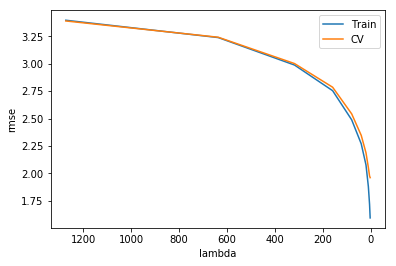

In [53]:
import matplotlib.pyplot as plt
plt.plot(lambda_val, rmse_train)
plt.plot(lambda_val, rmse_cv)
plt.ylabel('rmse')
plt.xlabel('lambda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'CV'], loc='upper right')
plt.show()

## Plot number of nonzeros per epoch

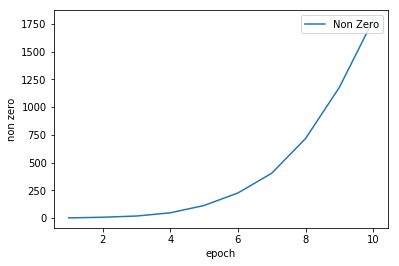

In [61]:
plt.plot(range(1, len(non_zero[1:]) + 1), non_zero[1:])
plt.ylabel('non zero')
plt.xlabel('epoch')
plt.legend(['Non Zero'], loc='upper right')
plt.show()

In [55]:
print(rmse(Y, X.T.dot(optimal_w) + optimal_b), rmse(Y_cv, X_cv.T.dot(optimal_w) + optimal_b))

1.5950020311239883 1.9618388378918905


In [56]:
# w_star, b_star = optimal_w.copy(), optimal_b.copy()

## Train on cross validation dataset

In [57]:
opt_lam = lambda_val[-1]
final_w, final_b = train(X_cv, Y_cv, optimal_w, optimal_b, opt_lam , 0.001)

34895.2535471
33803.6932534
33620.6432684
33556.3967488
33524.319691
33504.1875759
33489.3422145
33477.2685285
33467.1197221
33458.4705179
33450.906972
33444.216938
33438.2527671
33433.0018584
33428.3189934
33424.1255812
33420.3399827
33416.8661716
33413.6384262
33410.5970936
33407.6922128
33404.8798655
33402.12442
33399.3985841
33396.6839166
33393.967722
33391.2420415
33388.5057887
33385.7639845
33383.025726
33380.3033767
33377.6105008
33374.9614651
33372.3702971
33369.8507608
33367.4132805
33365.0679786
33362.8324663
33360.7022142
33358.6726154
33356.7383471
33354.8994027
33353.1575268
33351.5085696
33349.9483915
33348.4728952
33347.0788
33345.7614634
33344.516847
33343.3414064
33342.2318226
33341.1851466
33340.1982015
33339.2672485
33338.3890952
33337.5606871
33336.7789973
33336.0408173
33335.343665
33334.685424
33334.0640762
33333.4772865
33332.9224268
33332.3968902
33331.8983194
33331.4246999
33330.9741947
33330.5452118
33330.1363723
33329.7464764
33329.3744827
33329.0194769
33328

In [62]:
print(rmse(Y, X.T.dot(final_w) + final_b), rmse(Y_cv, X_cv.T.dot(final_w) + final_b))

1.9401854487998866 1.5778997832150354


## Get the top ten max valued and min valued features

In [74]:
top_10_feat_min = np.argsort(final_w)[:10]
top_10_feat_max = np.argsort(final_w)[-10:]
print(top_10_feat_max, top_10_feat_min)

[2817  825 1642   73 2573 2751 2469 2544  358  969] [2717 2258 1486 1185 2866 2627 1544 2821 2731 2628]


In [75]:
features = pd.read_csv('features.txt', header= None)
max_feat = []
min_feat = []
for i in top_10_feat_max:
    max_feat.append(features[0][i])
for i in top_10_feat_min:
    min_feat.append(features[0][i])
print(max_feat, min_feat)

['aromas flavors', 'pure varietal', 'flavors pineapples', 'straightforward', 'tannic dry', 'paired', 'bordeaux', 'big', 'stars', 'impressively'] ['blackberries black cherries', 'smoky oak flavors', 'soft', 'flavors blackberries currants', 'dry fruity', 'high', 'banana', 'low alcohol', 'followed', 'white']


## Compute predictions for test data

In [42]:
test = pd.read_csv('test.txt', header=None, sep = " ")
X_test = scipy.sparse.csr_matrix((test[2], (test[1] - 1, test[0] - 1)))
test_b = np.full(X_test.shape[1], final_b[0])
pred = X_test.T.dot(final_w) + test_b

In [43]:
submission = pd.read_csv('sampleSubmission.csv')
submission.Points = pred

In [44]:
submission.to_csv('test_res.csv', index=False)